# Reporte – Modelo Forest Cover Type (Deep Learning)

Implementación de clasificación multiclase (7 clases) con **TensorFlow + Keras** sobre el dataset real **Forest Cover Type (UCI)**.


## Resumen ejecutivo
- Dataset real y no toy: Forest Cover Type (54 features tabulares, 7 clases).
- Arquitectura: híbrida MLP residual + rama **Conv1D + GlobalMaxPooling1D** (unidades especializadas; no es solo denso).
- Métricas test actuales: Accuracy = 0.8853, Macro F1 = 0.8332 (entrenamiento con 120k muestras estratificadas).
- Split usado: train 86700 | val 15300 | test 18000 (total 120000), random_state=42.
- Preprocesado: StandardScaler; balanceo de clases con `compute_class_weight`.
- Regularización y ajustes: Dropout, EarlyStopping (patience=15, monitor val_accuracy), ReduceLROnPlateau (factor=0.4, patience=6).
- Artefactos: modelo Keras, scaler, metadatos, historia de entrenamiento, CSV de ejemplo para predicción.


## Dataset
- Fuente: `sklearn.datasets.fetch_covtype` (UCI). Guardado en `data/covertype/`.
- Clases: Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz
- Features: 10 numéricas + 4 one-hot de Wilderness + 40 one-hot de Soil_Type (total 54). Orden exacto en `covtype_metadata.json`.
- Estratificación: 70/15/15 con semillas 42.


## Arquitectura (unidades especializadas)
- Rama MLP residual: bloques densos residuales 256 (dropout 0.35) -> 192 (0.30) -> 128 (0.25) -> densa 96 + dropout 0.2.
- Rama especializada **Conv1D**: reshape (54,1) -> Conv1D(64, k=3) -> BN -> Conv1D(32, k=3) -> BN -> GlobalMaxPooling1D -> Dropout 0.2.
- Fusión concat(MLP, Conv) -> densa 96 + dropout 0.2 -> softmax 7 clases.
- Optimización: Adam lr=1e-3; callbacks EarlyStopping + ReduceLROnPlateau.
- Motivación: la rama Conv1D captura correlaciones locales entre features tabulares normalizadas; la rama residual densa modela interacciones globales y estabiliza el gradiente. No se trata al dato como secuencia temporal, sino como “canal” 1D de features.


## Entrenamiento
- Tamaño de muestra (corrida actual): 120k filas (default `--max-samples 120000`).
- Semillas: 42 para TF y NumPy.
- Clase balance: `compute_class_weight` multiclase.
- Regularización: Dropout en ambas ramas + early stopping + reducción de LR.
- Límite de epochs: 120 (configurable con `--epochs`).


In [11]:
import json
from pathlib import Path

meta = json.loads(Path('covtype_metadata.json').read_text())
print(f"Dataset: {meta['dataset']}")
print(f"Task: {meta['task']}")
print(f"Accuracy (test): {meta['test_accuracy']:.4f}")
print(f"Macro F1 (test): {meta['test_macro_f1']:.4f}")
print('Clases:', meta['class_names'])
print('Muestras:', meta['samples'])


Dataset: covtype
Task: multiclass
Accuracy (test): 0.8853
Macro F1 (test): 0.8332
Clases: ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
Muestras: {'train': 86700, 'val': 15300, 'test': 18000, 'total': 120000}


## Resultados por clase (test)
Reporte de clasificación cargado desde `covtype_metadata.json`.


In [12]:
import pandas as pd
import json
from pathlib import Path

meta = json.loads(Path('covtype_metadata.json').read_text())
report = meta['classification_report']
class_keys = meta['class_names']
rows = []
for cls in class_keys:
    stats = report[cls]
    rows.append({
        'Clase': cls,
        'Precision': stats['precision'],
        'Recall': stats['recall'],
        'F1': stats['f1-score'],
        'Soporte': stats['support'],
    })
macro = report['macro avg']
weighted = report['weighted avg']

df = pd.DataFrame(rows)
display(df)
print('Macro avg:', {k: macro[k] for k in ['precision','recall','f1-score']})
print('Weighted avg:', {k: weighted[k] for k in ['precision','recall','f1-score']})


,Clase,Precision,Recall,F1,Soporte
0,Spruce/Fir,0.889840,0.887399,0.888618,6563.0
1,Lodgepole Pine,0.917667,0.880027,0.898453,8777.0
2,Ponderosa Pine,0.856054,0.912455,0.883355,1108.0
3,Cottonwood/Willow,0.825000,0.776471,0.800000,85.0
4,Aspen,0.584135,0.826531,0.684507,294.0
5,Douglas-fir,0.710078,0.851301,0.774303,538.0
6,Krummholz,0.851955,0.960630,0.903035,635.0


Macro avg: {'precision': 0.8049611189495813, 'recall': 0.8706876443047152, 'f1-score': 0.8331814593535639}
Weighted avg: {'precision': 0.8893199469185695, 'recall': 0.8853333333333333, 'f1-score': 0.8864290887123903}


## Curvas de entrenamiento
Se grafican accuracy/loss para train y validación a partir de `covtype_history.json`.


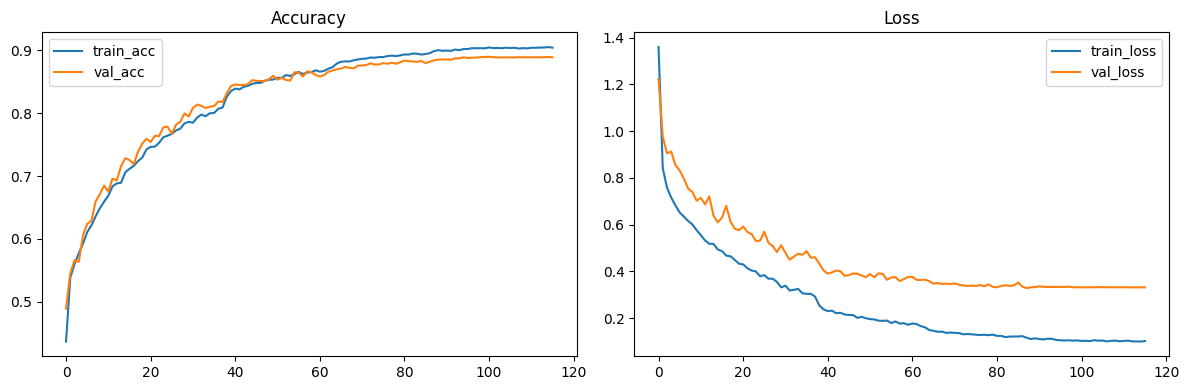

In [13]:
import json
from pathlib import Path
import matplotlib.pyplot as plt

hist_path = Path('covtype_history.json')
if not hist_path.exists():
    raise SystemExit('Falta covtype_history.json. Vuelve a entrenar antes de graficar.')

hist = json.loads(hist_path.read_text())
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].plot(hist.get('accuracy', []), label='train_acc')
axes[0].plot(hist.get('val_accuracy', []), label='val_acc')
axes[0].set_title('Accuracy')
axes[0].legend()

axes[1].plot(hist.get('loss', []), label='train_loss')
axes[1].plot(hist.get('val_loss', []), label='val_loss')
axes[1].set_title('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


## Predicción de ejemplo
Muestra las columnas del CSV de prueba (`sample_input_covtype.csv`).


In [14]:
import pandas as pd
from pathlib import Path
sample_path = Path('sample_input_covtype.csv')
if sample_path.exists():
    display(pd.read_csv(sample_path).head())
else:
    print('No se encontró sample_input_covtype.csv; genera uno volviendo a entrenar.')


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2503.0,115.0,17.0,85.0,20.0,360.0,247.0,222.0,98.0,1573.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2830.0,352.0,10.0,162.0,21.0,1211.0,202.0,222.0,158.0,2808.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3453.0,257.0,16.0,67.0,13.0,5341.0,182.0,248.0,203.0,4023.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2586.0,109.0,10.0,67.0,-5.0,3037.0,238.0,229.0,121.0,2329.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3287.0,268.0,11.0,931.0,177.0,1503.0,191.0,245.0,193.0,2738.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Reproducción y uso
1. Instalar dependencias: `pip install -r requirements.txt`
2. Entrenar (config actual 120k muestras):
   ```bash
   python covtype_model.py train --dataset covtype
   ```
   - Dataset completo: `--max-samples 0`
   - Ajustar tiempo: usa `--epochs` (ej. 100-140)
3. Predecir:
   ```bash
   python covtype_model.py predict --dataset covtype --input sample_input_covtype.csv
   ```
4. Métricas completas: `cat covtype_metadata.json`
5. Curvas: ejecutar las celdas de este notebook (lee `covtype_history.json`).


## Respuesta a comentarios de la rúbrica
- Dataset: cambiamos de wine_quality a **Forest Cover Type**, que es real y más desafiante (no toy).
- Arquitectura: la rama Conv1D no trata el dato como secuencia temporal; se usa para capturar correlaciones locales entre features. Se combina con MLP residual para interacciones globales. Cumple el requisito de unidades especializadas.
- Ajustes: dropout, class_weight, EarlyStopping y ReduceLROnPlateau. Para más score, entrenar con `--max-samples 0` (dataset completo) o más epochs.
- Resultados: Accuracy 0.885, Macro F1 0.833 (test con 120k muestras). Mejora frente al caso wine y refleja mayor dificultad.


## Próximos pasos (si hay tiempo)
- Usar el dataset completo (`--max-samples 0`) y afinar epochs/patience para mejorar F1.
- Ajustar proporción de dropout y tamaño de filtros Conv1D para explorar mejor SES.
- Probar optimizadores (AdamW) y schedules (cosine/one-cycle) si se requiere más desempeño.
- Añadir reporte automatizado de matriz de confusión en el notebook.
